In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Để tạo dữ liệu mẫu
from sklearn.datasets import make_blobs

# Hàm trợ giúp để vẽ các ellipse thể hiện hiệp phương sai
def plot_gmm_covariance(ax, means, covariances, weights, n_std=2.0, facecolor='none', **kwargs):
    """Vẽ các ellipse thể hiện các thành phần Gaussian của GMM."""
    for k in range(len(means)):
        cov = covariances[k]
        mean = means[k]

        # Tìm eigenvalues và eigenvectors để xác định hướng và kích thước của ellipse
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals = vals[order]
        vecs = vecs[:, order]

        # Lấy góc quay từ eigenvector đầu tiên
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        # Lấy chiều rộng và chiều cao từ eigenvalues
        # Chiều rộng/cao là n_std lần căn bậc hai của eigenvalue
        width, height = 2 * n_std * np.sqrt(vals)

        # Tạo ellipse
        ell = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
        ell.set_facecolor(facecolor)
        ell.set_edgecolor('red')
        ell.set_linewidth(2)
        ax.add_patch(ell)


class GaussianMixtureModel:
    """
    Triển khai Gaussian Mixture Model bằng NumPy.
    Huấn luyện bằng thuật toán Expectation-Maximization.
    """
    def __init__(self, n_components, n_iters=150, tol=1e-4, reg_cov=1e-6):
        """
        Khởi tạo mô hình.

        Args:
            n_components (int): Số lượng cụm Gaussian (K).
            n_iters (int): Số vòng lặp tối đa cho thuật toán EM.
            tol (float): Ngưỡng hội tụ của log-likelihood.
            reg_cov (float): Giá trị nhỏ để cộng vào đường chéo của ma trận hiệp phương sai
                             nhằm đảm bảo ma trận luôn khả nghịch.
        """
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.reg_cov = reg_cov

        # Các tham số của mô hình sẽ được học
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.log_likelihood_history_ = []

    def _multivariate_normal_pdf(self, X, mean, covariance):
        """
        Tính toán hàm mật độ xác suất (PDF) của phân phối Gaussian đa biến.
        """
        n_features = X.shape[1]
        det_cov = np.linalg.det(covariance)
        inv_cov = np.linalg.inv(covariance)

        norm_const = 1.0 / (np.power(2 * np.pi, n_features / 2) * np.sqrt(det_cov))

        X_minus_mu = X - mean
        exponent = -0.5 * np.sum(np.dot(X_minus_mu, inv_cov) * X_minus_mu, axis=1)

        return norm_const * np.exp(exponent)

    def fit(self, X):
        """
        Huấn luyện mô hình GMM trên dữ liệu X bằng thuật toán EM.

        Args:
            X (np.array): Dữ liệu huấn luyện, shape (n_samples, n_features).
        """
        n_samples, n_features = X.shape

        # --- 1. Khởi tạo tham số ---
        # Trọng số: khởi tạo đều
        self.weights_ = np.ones(self.n_components) / self.n_components

        # Trung bình: chọn ngẫu nhiên K điểm từ dữ liệu
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[random_indices]

        # Hiệp phương sai: khởi tạo là các ma trận đơn vị
        self.covariances_ = [np.eye(n_features) for _ in range(self.n_components)]

        self.log_likelihood_history_ = []

        # --- Bắt đầu vòng lặp EM ---
        for i in range(self.n_iters):
            # --- 2. E-Step (Expectation) ---
            # Tính toán "trách nhiệm" (responsibilities), gamma(z_nk)

            # (n_samples, n_components)
            responsibilities = np.zeros((n_samples, self.n_components))

            for k in range(self.n_components):
                # Tính PDF cho tất cả các điểm đối với cụm k
                pdf = self._multivariate_normal_pdf(X, self.means_[k], self.covariances_[k])
                responsibilities[:, k] = self.weights_[k] * pdf

            # Chuẩn hóa responsibilities để tổng mỗi hàng bằng 1
            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
            self.log_likelihood_history_.append(log_likelihood)

            # Chia cho tổng để có xác suất posterior
            responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

            # --- 3. M-Step (Maximization) ---
            # Cập nhật lại các tham số dựa trên responsibilities

            # Tính N_k: tổng "trọng số" của các điểm trong mỗi cụm
            N_k = np.sum(responsibilities, axis=0)

            # Cập nhật trọng số (pi_k)
            self.weights_ = N_k / n_samples

            # Cập nhật trung bình (mu_k)
            self.means_ = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]

            # Cập nhật hiệp phương sai (sigma_k)
            new_covariances = []
            for k in range(self.n_components):
                X_minus_mu = X - self.means_[k]
                # Công thức: (1/N_k) * sum(r_ik * (x_i - mu_k)(x_i - mu_k)^T)
                cov_k = np.dot((responsibilities[:, k] * X_minus_mu.T), X_minus_mu) / N_k[k]
                # Thêm giá trị nhỏ để đảm bảo ma trận khả nghịch
                cov_k += np.eye(n_features) * self.reg_cov
                new_covariances.append(cov_k)
            self.covariances_ = new_covariances

            # --- 4. Kiểm tra hội tụ ---
            if i > 0 and np.abs(log_likelihood - self.log_likelihood_history_[-2]) < self.tol:
                print(f"Hội tụ tại vòng lặp thứ {i+1}.")
                break

        print("Huấn luyện hoàn tất.")

    def predict_proba(self, X):
        """
        Dự đoán xác suất một điểm dữ liệu thuộc về từng cụm.
        """
        if self.means_ is None:
            raise RuntimeError("Bạn phải huấn luyện mô hình trước khi dự đoán.")

        responsibilities = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            pdf = self._multivariate_normal_pdf(X, self.means_[k], self.covariances_[k])
            responsibilities[:, k] = self.weights_[k] * pdf

        # Chuẩn hóa để tổng mỗi hàng bằng 1
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def predict(self, X):
        """
        Gán mỗi điểm dữ liệu vào cụm có xác suất cao nhất.
        """
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

Hội tụ tại vòng lặp thứ 13.
Huấn luyện hoàn tất.


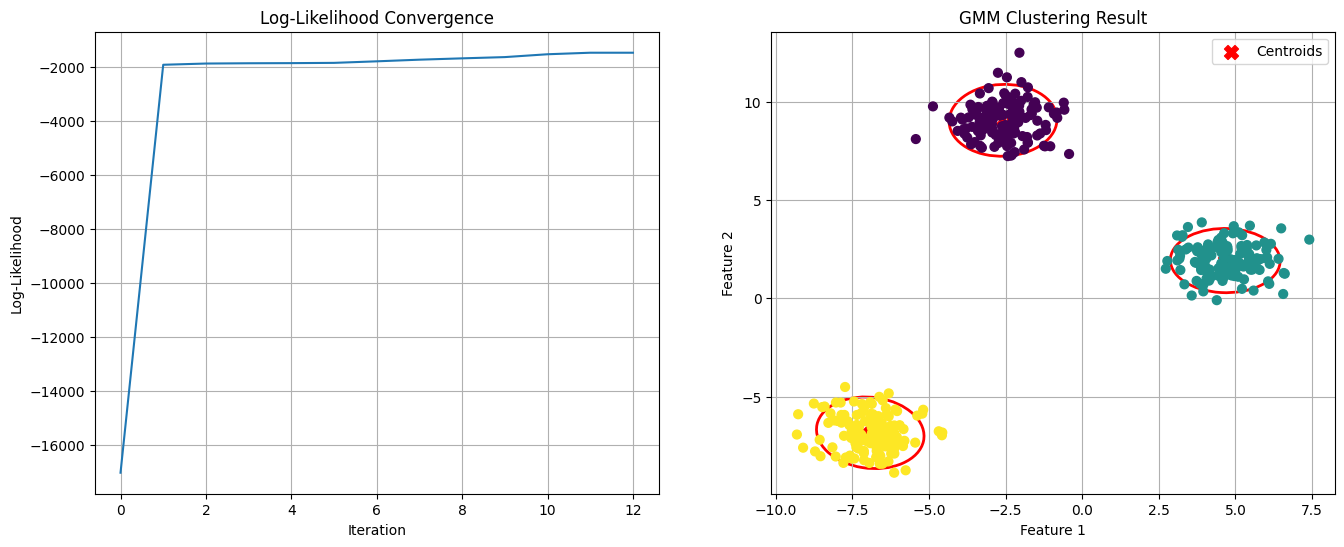


Các tham số đã học được:
Trọng số (Weights): [0.335  0.3325 0.3325]


In [2]:
# --- Tạo dữ liệu mẫu ---
X, y_true = make_blobs(n_samples=400, centers=3,
                       cluster_std=0.90, random_state=42)

# --- Khởi tạo và huấn luyện mô hình GMM ---
n_clusters = 3
gmm = GaussianMixtureModel(n_components=n_clusters, n_iters=150, tol=1e-4)
gmm.fit(X)

# --- Dự đoán nhãn cụm ---
labels = gmm.predict(X)

# --- Trực quan hóa kết quả ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: Log-Likelihood qua các vòng lặp
ax1.plot(gmm.log_likelihood_history_)
ax1.set_title('Log-Likelihood Convergence')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log-Likelihood')
ax1.grid(True)

# Biểu đồ 2: Kết quả phân cụm
ax2.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
ax2.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=100, marker='X', label='Centroids')
plot_gmm_covariance(ax2, gmm.means_, gmm.covariances_, gmm.weights_)

ax2.set_title('GMM Clustering Result')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
ax2.grid(True)
plt.show()

# In ra các tham số đã học được
print("\nCác tham số đã học được:")
print("Trọng số (Weights):", gmm.weights_)
# print("\nTrung bình (Means):\n", gmm.means_)
# print("\nHiệp phương sai (Covariances):\n", gmm.covariances_[0]) # In ra cái đầu tiên làm ví dụ

Đang huấn luyện mô hình GMM (phiên bản tự cài đặt, có thể sẽ chậm hơn sklearn)...
Huấn luyện hoàn tất.
Huấn luyện hoàn tất trong 6.10 giây.
Các màu trung tâm của các cụm (R, G, B):
[[0.16461974 0.18605463 0.11476398]
 [0.28216476 0.35518873 0.17877807]
 [0.66786439 0.65128733 0.56416517]
 [0.26747711 0.34301382 0.18636505]]
Cụm được xác định là nền có nhãn: 2


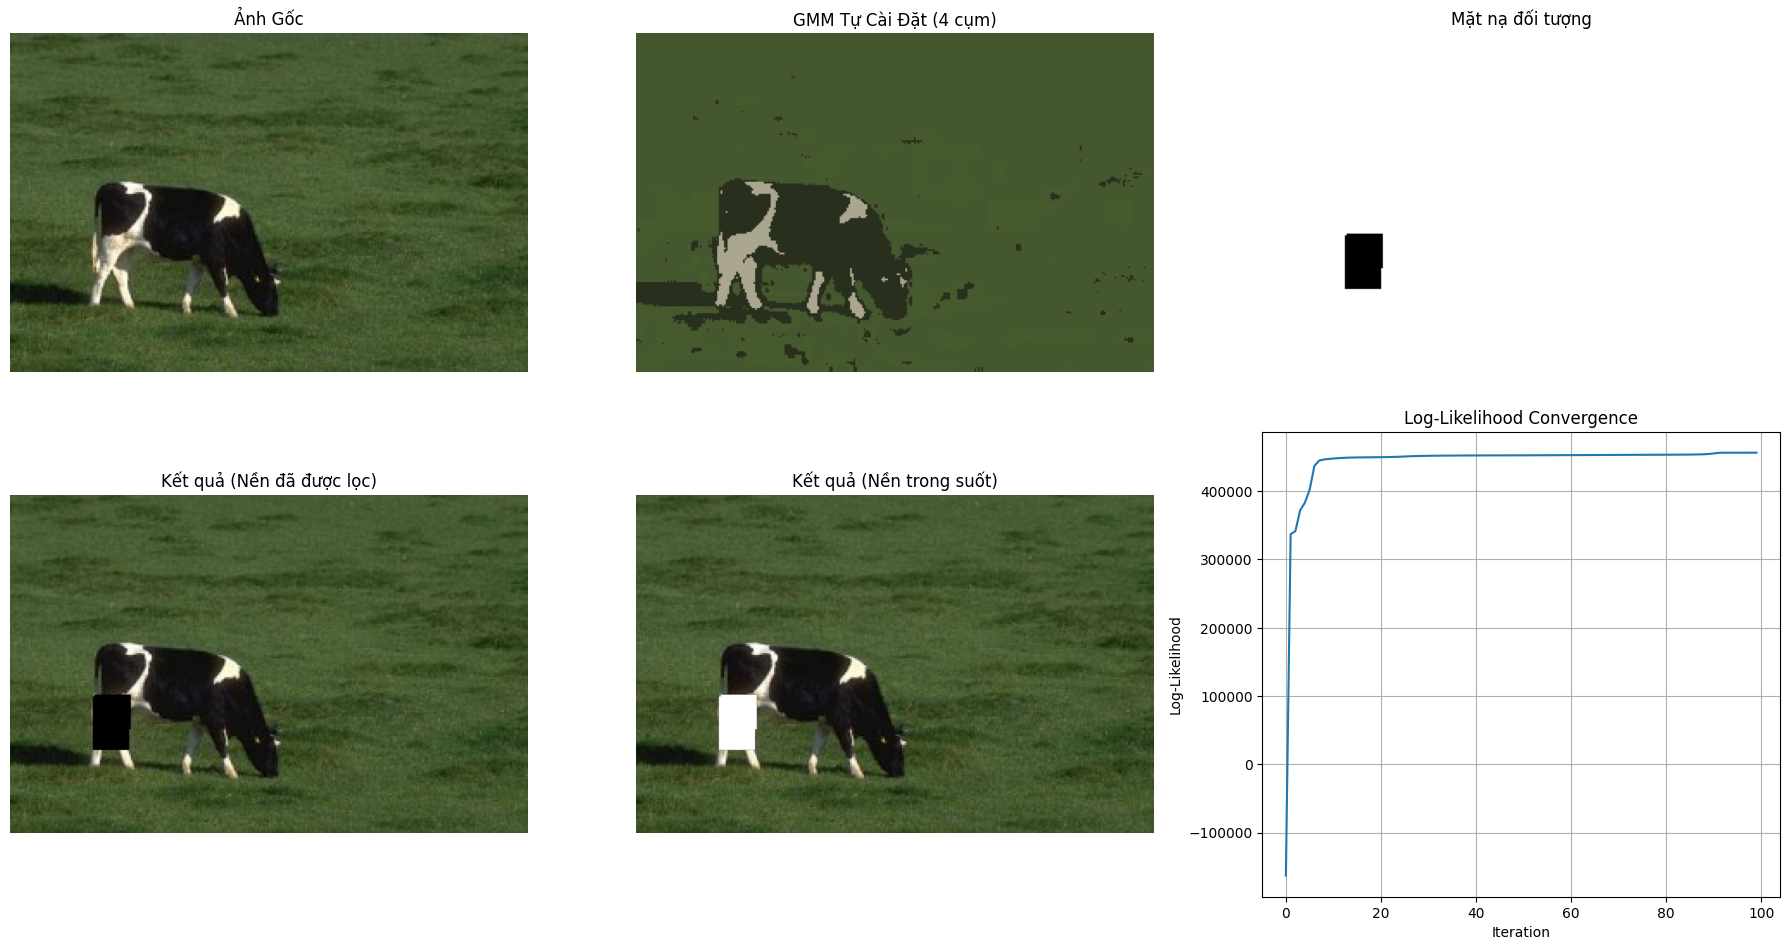

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import time # Thêm thư viện time để đo thời gian
# Đặt seed để kết quả có thể tái lập
np.random.seed(42)

# --- 1. Đọc và chuẩn bị ảnh ---
image = cv2.imread('cow.jpg')
if image is None:
    raise FileNotFoundError("Không tìm thấy file ảnh 'cow.png'. Hãy đảm bảo file nằm cùng thư mục.")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image_rgb.shape
pixels = image_rgb.reshape(-1, 3)
pixels_normalized = pixels / 255.0

# --- 3. Huấn luyện mô hình GMM TỰ CÀI ĐẶT ---
n_components = 4

# Khởi tạo mô hình TỰ CÀI ĐẶT
gmm = GaussianMixtureModel(n_components=n_components, n_iters=100, tol=1e-4)

print("Đang huấn luyện mô hình GMM (phiên bản tự cài đặt, có thể sẽ chậm hơn sklearn)...")
start_time = time.time()
gmm.fit(pixels_normalized)
end_time = time.time()
print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây.")


# Dự đoán nhãn cụm cho mỗi pixel
labels = gmm.predict(pixels_normalized)

# --- 4. Xác định cụm nền (Background Cluster) ---
# Logic này không đổi vì lớp của chúng ta cũng lưu means vào self.means_
background_cluster_label = np.argmax(gmm.means_[:, 1])
print(f"Các màu trung tâm của các cụm (R, G, B):\n{gmm.means_}")
print(f"Cụm được xác định là nền có nhãn: {background_cluster_label}")

# --- 5. Tạo và làm sạch mặt nạ ---
foreground_mask = ~(labels == background_cluster_label)
foreground_mask = foreground_mask.reshape(height, width)

kernel = np.ones((5, 5), np.uint8)
foreground_mask_cleaned = cv2.morphologyEx(foreground_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)
foreground_mask_cleaned = cv2.morphologyEx(foreground_mask_cleaned.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=3)

# --- 6. Áp dụng mặt nạ để tách nền ---
mask_3d = np.stack([foreground_mask_cleaned] * 3, axis=-1)
result_image = image_rgb * mask_3d

# --- 7. Trực quan hóa kết quả ---
plt.figure(figsize=(18, 10))

# 1. Ảnh gốc
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title('Ảnh Gốc')
plt.axis('off')

# 2. Ảnh đã phân đoạn bởi GMM
# Kỹ thuật này vẫn hoạt động vì gmm.means_ và labels có cấu trúc đúng
segmented_image = gmm.means_[labels].reshape(height, width, 3)
# Cần clip giá trị về [0, 1] vì có thể có lỗi số học nhỏ
plt.subplot(2, 3, 2)
plt.imshow(np.clip(segmented_image, 0, 1))
plt.title(f'GMM Tự Cài Đặt ({n_components} cụm)')
plt.axis('off')

# 3. Mặt nạ đối tượng (đã làm sạch)
plt.subplot(2, 3, 3)
plt.imshow(foreground_mask_cleaned, cmap='gray')
plt.title('Mặt nạ đối tượng')
plt.axis('off')

# 4. Kết quả cuối cùng
plt.subplot(2, 3, 4)
plt.imshow(result_image)
plt.title('Kết quả (Nền đã được lọc)')
plt.axis('off')

# 5. Đặt nền trong suốt (PNG)
result_rgba = cv2.cvtColor(result_image, cv2.COLOR_RGB2RGBA)
result_rgba[:, :, 3] = foreground_mask_cleaned * 255
plt.subplot(2, 3, 5)
plt.imshow(result_rgba)
plt.title('Kết quả (Nền trong suốt)')
plt.axis('off')

# 6. Biểu đồ Log-Likelihood
plt.subplot(2, 3, 6)
plt.plot(gmm.log_likelihood_history_)
plt.title('Log-Likelihood Convergence')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)


# Lưu ảnh kết quả với nền trong suốt
cv2.imwrite('cow_no_background_custom_gmm.png', cv2.cvtColor(result_rgba, cv2.COLOR_RGBA2BGRA))

plt.tight_layout()
plt.show()

Đang huấn luyện mô hình GMM...
Huấn luyện hoàn tất.
Các màu trung tâm của các cụm (R, G, B):
[[0.28190654 0.35714421 0.20157799]
 [0.25418604 0.32839254 0.16276705]
 [0.38782846 0.40155793 0.30712209]
 [0.08328181 0.07764967 0.07034169]]
Cụm được xác định là nền có nhãn: 2


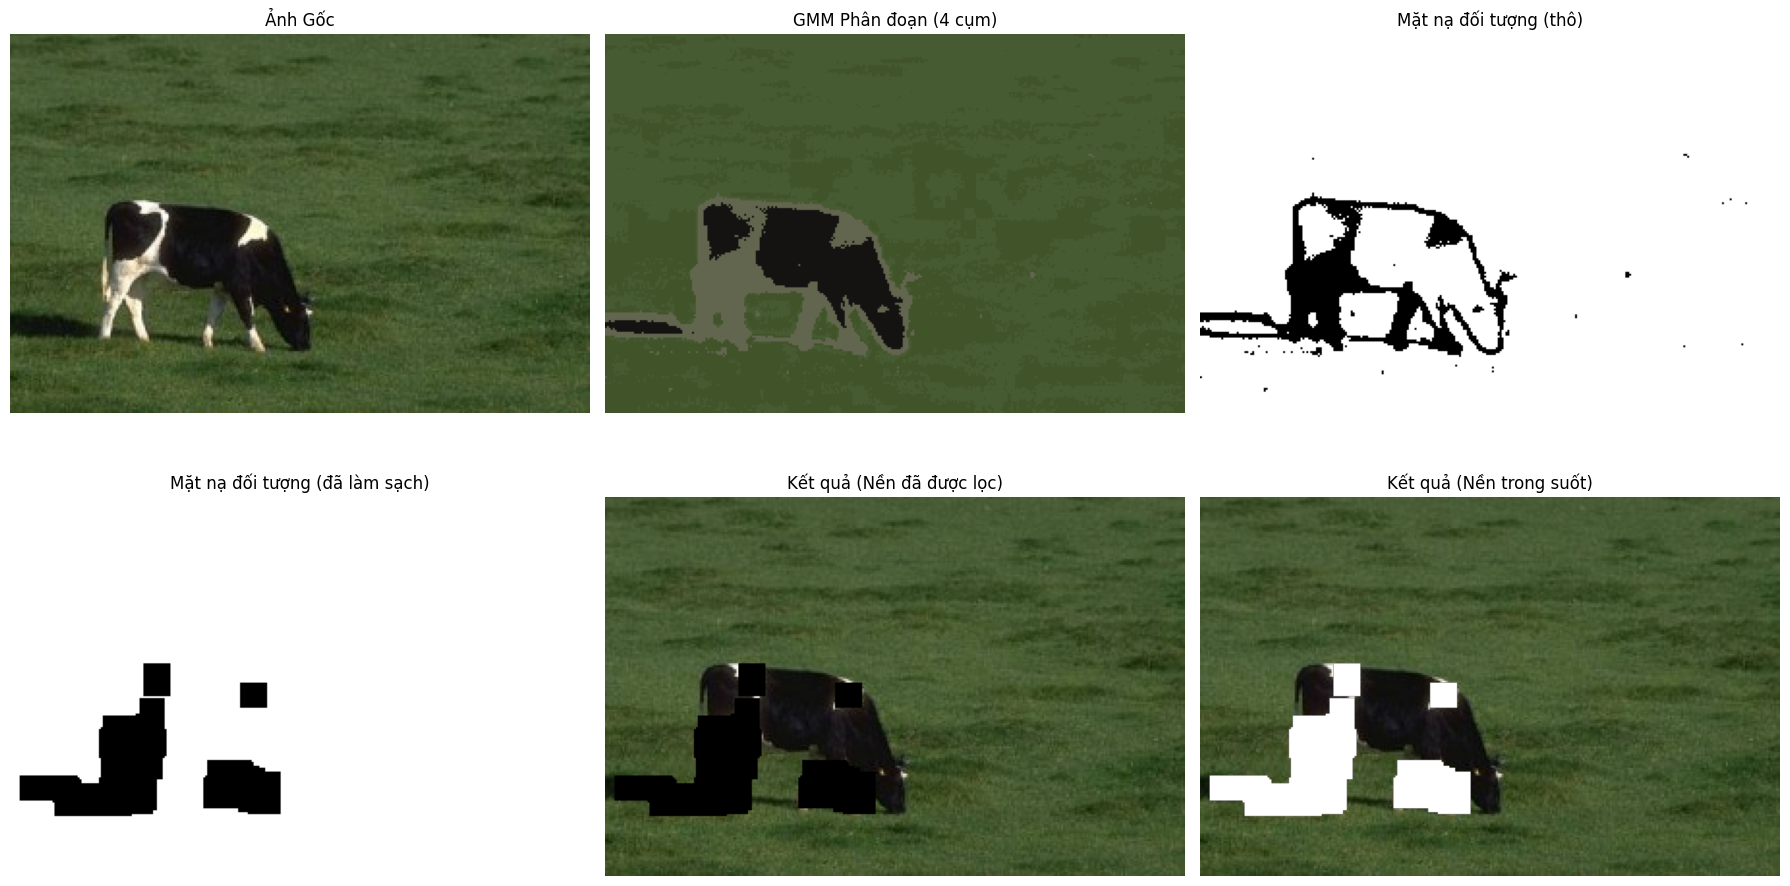

In [6]:
from sklearn.mixture import GaussianMixture

# --- 1. Đọc và chuẩn bị ảnh ---

# Đọc ảnh bằng OpenCV
image = cv2.imread('cow.jpg')
if image is None:
    raise FileNotFoundError("Không tìm thấy file ảnh 'cow.png'. Hãy đảm bảo file nằm cùng thư mục.")

# OpenCV đọc ảnh theo định dạng BGR, chuyển sang RGB để hiển thị và xử lý màu sắc trực quan hơn
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Lấy kích thước ảnh
height, width, _ = image_rgb.shape

# --- 2. Chuẩn bị dữ liệu cho GMM ---

# Chuyển đổi ảnh từ 3D (height, width, 3) thành 2D (n_pixels, 3)
pixels = image_rgb.reshape(-1, 3)

# Chuẩn hóa giá trị pixel về khoảng [0, 1] để GMM hoạt động tốt hơn
pixels_normalized = pixels / 255.0

# --- 3. Huấn luyện mô hình GMM ---

n_components = 4
print("Đang huấn luyện mô hình GMM...")
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(pixels_normalized)
print("Huấn luyện hoàn tất.")

# Dự đoán nhãn cụm cho mỗi pixel
labels = gmm.predict(pixels_normalized)

# --- 4. Xác định cụm nền (Background Cluster) ---

# Cụm nền (cỏ) sẽ có màu trung tâm với thành phần Xanh lá (Green) cao nhất.
background_cluster_label = np.argmax(gmm.means_[:, 1])
print(f"Các màu trung tâm của các cụm (R, G, B):\n{gmm.means_}")
print(f"Cụm được xác định là nền có nhãn: {background_cluster_label}")

# --- 5. Tạo mặt nạ (Mask) ---

# Tạo một mặt nạ True/False.
foreground_mask = ~(labels == background_cluster_label)
foreground_mask = foreground_mask.reshape(height, width)

# --- (Tùy chọn) Cải thiện mặt nạ bằng Morphological Operations ---
kernel = np.ones((5, 5), np.uint8)
foreground_mask_cleaned = cv2.morphologyEx(foreground_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)
foreground_mask_cleaned = cv2.morphologyEx(foreground_mask_cleaned.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=3)


# --- 6. Áp dụng mặt nạ để tách nền ---
mask_3d = np.stack([foreground_mask_cleaned]*3, axis=-1)
result_image = image_rgb * mask_3d

# --- 7. Trực quan hóa kết quả ---
plt.figure(figsize=(18, 10))

# 1. Ảnh gốc
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title('Ảnh Gốc')
plt.axis('off')

# 2. Ảnh đã phân đoạn bởi GMM (tô màu theo cụm)
segmented_image = gmm.means_[labels].reshape(height, width, 3)
plt.subplot(2, 3, 2)
plt.imshow(segmented_image)
plt.title(f'GMM Phân đoạn ({n_components} cụm)')
plt.axis('off')

# 3. Mặt nạ đối tượng (chưa làm sạch)
plt.subplot(2, 3, 3)
plt.imshow(foreground_mask, cmap='gray')
plt.title('Mặt nạ đối tượng (thô)')
plt.axis('off')

# 4. Mặt nạ đối tượng (đã làm sạch)
plt.subplot(2, 3, 4)
plt.imshow(foreground_mask_cleaned, cmap='gray')
plt.title('Mặt nạ đối tượng (đã làm sạch)')
plt.axis('off')

# 5. Kết quả cuối cùng
plt.subplot(2, 3, 5)
plt.imshow(result_image)
plt.title('Kết quả (Nền đã được lọc)')
plt.axis('off')

# 6. Đặt nền trong suốt (PNG)
result_rgba = cv2.cvtColor(result_image, cv2.COLOR_RGB2RGBA)
result_rgba[:, :, 3] = foreground_mask_cleaned * 255
plt.subplot(2, 3, 6)
plt.imshow(result_rgba)
plt.title('Kết quả (Nền trong suốt)')
plt.axis('off')

# *** DÒNG ĐÃ ĐƯỢC SỬA LỖI ***
# Lưu ảnh kết quả với nền trong suốt, chuyển từ RGBA sang BGRA cho OpenCV
cv2.imwrite('cow_no_background.png', cv2.cvtColor(result_rgba, cv2.COLOR_RGBA2BGRA))

plt.tight_layout()
plt.show()